In [201]:
from datetime import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Point cloud name
DATASET = 'Paris_lille'
CLOUD = 'Lille_0'

# Input folder and timestamp to search for. Timestamp can be "latest" or a specific timestmap
FOLDER = os.path.join("out", CLOUD)
TIMESTAMP = 'latest'

# Output folder for the plots
PLOT_FOLDER = os.path.join("out", "plots", DATASET, CLOUD)
os.makedirs(PLOT_FOLDER, exist_ok=True)

# Function to get the file based on the specified timestamp in the filename
def get_file_by_date(folder, date_str):
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {folder}")
    
    if TIMESTAMP == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        latest_file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),  # Join list and then replace
            "%Y-%m-%d-%H:%M:%S"  # Correct datetime format
        ))
        print(f"Loading latest file: {latest_file}")
        return latest_file
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            timestamp_str = filename.split('-')[1:]  # Split to get timestamp part
            timestamp_str = '-'.join(timestamp_str).replace('.csv', '')  # Rebuild timestamp string
            
            if date_str == timestamp_str:
                print(f"Loading file: {file}")
                return file
        raise FileNotFoundError(f"File with date '{date_str}' not found in folder: {folder}")

In [202]:
# Read the file and put into pandas dataframe
data = get_file_by_date(FOLDER, TIMESTAMP)
df = pd.read_csv(data)

# Convert times to milliseconds
df['mean'] = df['mean'] * 1000
df['stdev'] = df['stdev'] * 1000


# Define a consistent color palette for 'octree' categories
octree_types = df['octree'].unique()
palette = sns.color_palette("Set2", len(octree_types))
color_dict = dict(zip(octree_types, palette))

# Create a function for adding execution details to plot titles
def get_execution_details(data):
    search_size = data['num_searches'].iloc[0]
    repeats = data['repeats'].iloc[0]
    return f'\n\nSearch Size: {search_size:,} points, Repeats: {repeats}\n\nPoint cloud {CLOUD} in dataset {DATASET}'

# Set style for scientific paper
plt.style.use('seaborn')
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,  # Slightly larger for subplot titles
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.axisbelow': True
})

Loading latest file: out/Lille_0/Lille_0-2024-12-19-18:56:27.csv


In [203]:
df.dtypes

date                object
octree              object
point_type          object
encoder             object
npoints              int64
operation           object
kernel              object
radius             float64
num_searches         int64
repeats              int64
accumulated        float64
mean               float64
median             float64
stdev              float64
used_warmup          int64
avg_result_size      int64
dtype: object

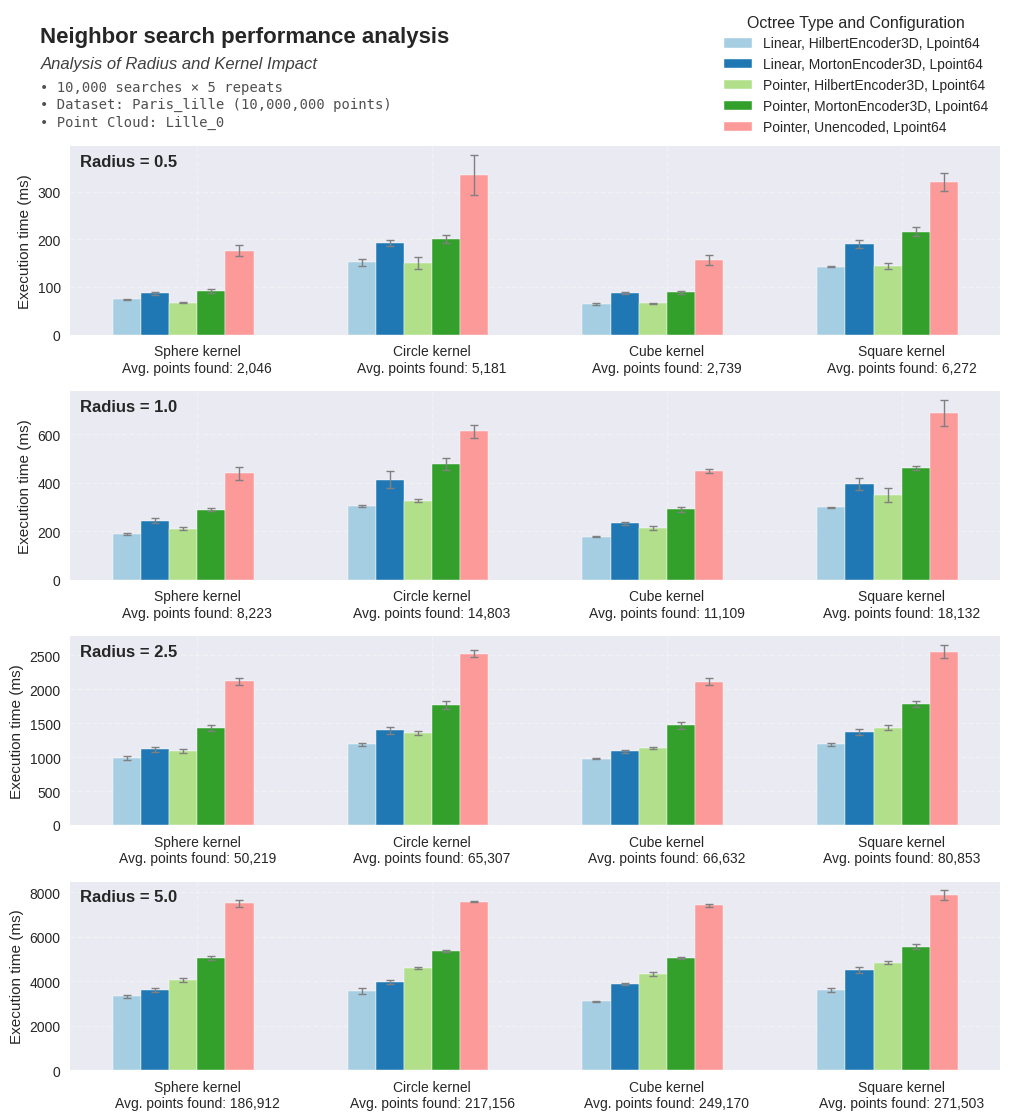

In [204]:
def radii_kernel_performance_matrix(df, operation, operation_name):
    # Get unique parameter combinations
    parameter_combinations = df[['octree', 'encoder', 'point_type']].drop_duplicates().sort_values(
        by=['octree', 'encoder', 'point_type'], ascending=[True, True, True]
    )
    palette = sns.color_palette("Paired", len(parameter_combinations))
    color_dict = {
        (row['octree'], row['encoder'], row['point_type']): color
        for row, color in zip(parameter_combinations.to_dict(orient='records'), palette)
    }
   
    # Filter for the specified operation
    operation_df = df[df['operation'] == operation]
   
    # Get unique radii and kernels
    radii = sorted(operation_df['radius'].unique())
    kernels = operation_df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)), 
                              gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
   
    bar_width = 0.15  # Width of individual bars
    group_width = bar_width * len(parameter_combinations)  # Total width of kernel group
    group_gap = 0.5  # Space between kernel groups
   
    legend_handles, legend_labels = [], []
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
   
    # First loop through each radius
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = operation_df[operation_df['radius'] == radius]
       
        # Now iterate through kernels
        kernel_labels = [] 
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
            
            # Finally, iterate through octree implementations identified by the (octree, encoer, point_type) tuple
            for j, (_, combination) in enumerate(parameter_combinations.iterrows()):
                octree, encoder, point_type = combination['octree'], combination['encoder'], combination['point_type']
                octree_data = kernel_data[
                    (kernel_data['octree'] == octree) & 
                    (kernel_data['encoder'] == encoder) & 
                    (kernel_data['point_type'] == point_type)
                ]

                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                bar = ax.bar(x_pos, means[0], bar_width, 
                                color=color_dict[(octree, encoder, point_type)])
                ax.errorbar(x_pos, means[0], stdevs[0], 
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
                
                if radius_idx == 0 and (octree, encoder, point_type) not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append((octree, encoder, point_type))

        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        
        ax.text(0.01, 0.96, f'Radius = {radius}', 
                transform=ax.transAxes,
                fontsize=12, fontweight='bold',
                va='top', ha='left')
        
        ax.set_ylabel('Execution time (ms)')
   
    fig.legend(
        legend_handles,
        [f"{octree}, {encoder}, {point_type}" for octree, encoder, point_type in legend_labels],
        title="Octree Type and Configuration",
        loc="upper right",
        bbox_to_anchor=(0.9, 1),
        fontsize=10
    )

    fig.text(0.10, 0.98, 
            f"{operation_name} performance analysis", 
            fontsize=16, 
            fontweight='bold', 
            ha='left', 
            va='top')

    fig.text(0.10, 0.955,
            f"Analysis of Radius and Kernel Impact",
            fontsize=12,
            fontstyle='italic',
            color='#404040',
            ha='left',
            va='top')

    execution_details = [
        f"• {nsearches:,} searches × {nrepeats:,} repeats",
        f"• Dataset: {DATASET} ({npoints:,} points)",
        f"• Point Cloud: {CLOUD}"
    ]
    fig.text(0.10, 0.935,
            '\n'.join(execution_details),
            fontsize=10,
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)

    return fig

fig = radii_kernel_performance_matrix(df, 'neighSearch', 'Neighbor search')
plt.savefig(os.path.join(PLOT_FOLDER, 'neighbor_search_performance.png'), dpi=300, bbox_inches='tight')

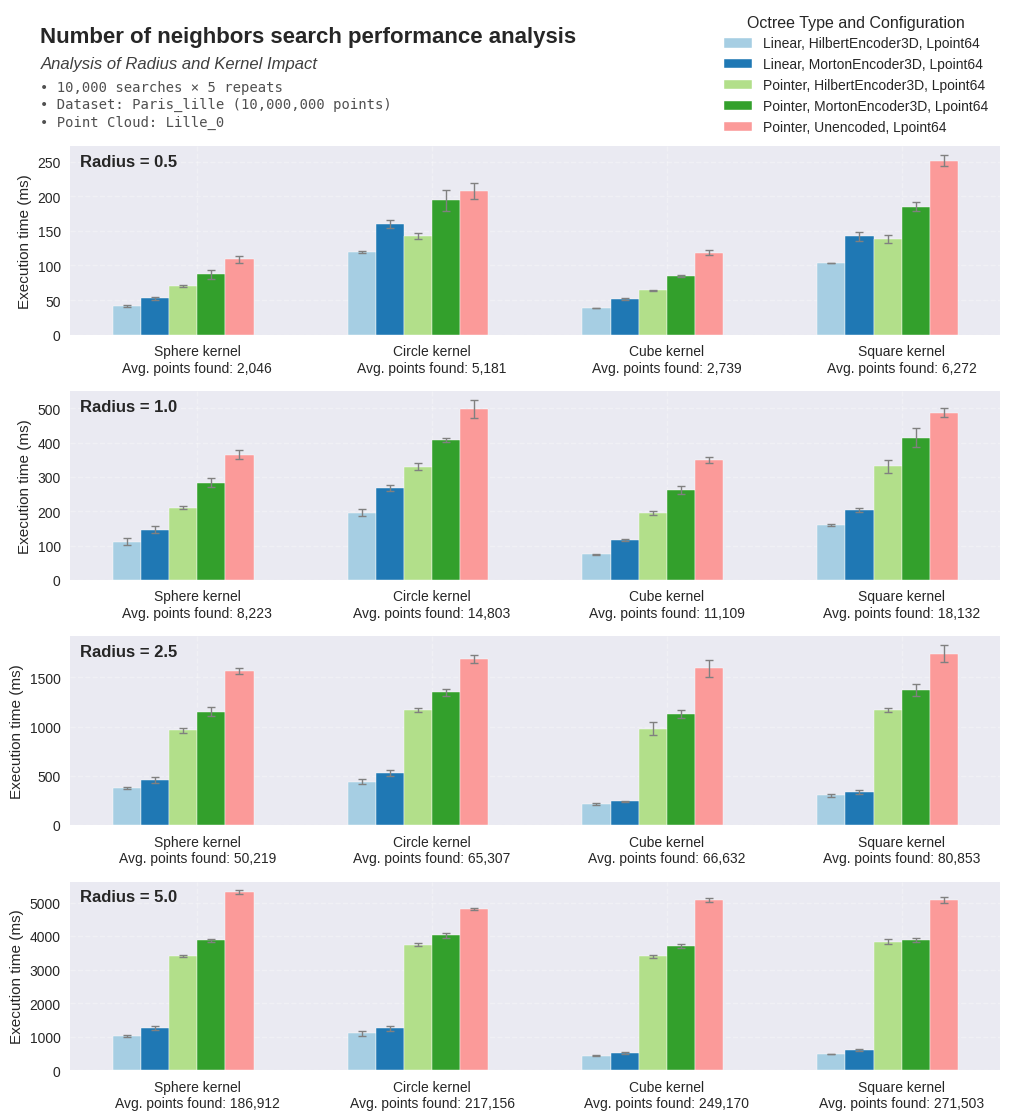

In [205]:
fig = radii_kernel_performance_matrix(df, 'numNeighSearch', 'Number of neighbors search')
plt.savefig(os.path.join(PLOT_FOLDER, 'num_neighbor_performance.png'), dpi=300, bbox_inches='tight')